In [23]:
import pandas as pd
import numpy as np
import os

# Load the new CSV file
filtered_data = pd.read_csv("happy_angry_emotions.csv")

# Split the data into features (X) and labels (y)
X = filtered_data.drop(columns=["Emotion"])  # Features (everything except 'Emotion' column)
y = filtered_data["Emotion"]  # Labels (Emotion column)

# Convert labels to numeric values (03 -> 1 for happy, 05 -> 0 for angry)
y = y.replace({"03": 1, "05": 0})

# Normalize the features (important for neural networks)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display the first few rows of the features and labels
print("Features (X):")
print(X_scaled[:5])  # Show first 5 rows of the normalized features
print("\nLabels (y):")
print(y.head())  # Show first few labels


Features (X):
[[-0.19237029 -0.8376315   0.49335786  0.58885395 -0.61889854 -0.79779185
   0.06380532 -0.09420363 -0.76004304 -0.2476004  -1.00494398  0.3450671
  -0.52028863  0.3694276  -0.39653729]
 [ 0.79229332 -0.90954847  0.27070153 -0.06142884 -0.24763428 -1.11204805
  -0.70344275  0.13728512  0.01274529 -0.57654477 -0.24640569  1.02505611
  -0.70769493  0.20536161  0.28729781]
 [-0.09976717 -0.64001608  0.32435288 -0.07894693  0.0942357  -0.27093884
  -0.5392683  -0.93878586 -0.36338163 -0.05770249  0.49497677  1.07980864
  -0.4077102   0.52914865 -0.43043005]
 [-0.51196264 -0.33973999  0.388381    0.18430613  0.54421006 -0.14410129
   0.18627353 -0.53377257 -0.34751821  0.81432499  1.0327681   0.51460472
  -0.81526925  0.82224761 -0.63716145]
 [-0.23252705 -0.29059462 -0.01653806 -0.50356736  0.11693013 -0.39882407
  -0.06682594 -0.86751019 -0.84881668 -0.13557252  0.19865275  0.86701495
  -1.03940803  0.64915111 -0.42925224]]

Labels (y):
0    5
1    5
2    3
3    3
4    3
Nam

In [24]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Display the shape of the resulting sets to confirm
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training features shape: (307, 15)
Testing features shape: (77, 15)
Training labels shape: (307,)
Testing labels shape: (77,)


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.replace({3: 0, 5: 1}).values, dtype=torch.float32)  # Use float for BCELoss
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.replace({3: 0, 5: 1}).values, dtype=torch.float32)  # Use float for BCELoss

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network model (single output neuron for binary classification)
class EmotionModel(nn.Module):
    def __init__(self):
        super(EmotionModel, self).__init__()
        self.fc1 = nn.Linear(15, 64)  # First hidden layer (15 features input, 64 neurons)
        self.fc2 = nn.Linear(64, 32)  # Second hidden layer (64 neurons input, 32 neurons)
        self.fc3 = nn.Linear(32, 1)   # Output layer (1 neuron for binary classification)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()   # Sigmoid for binary classification (outputs a probability)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% dropout rate

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first hidden layer
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)  # Apply sigmoid for binary classification
        return x


# Initialize the model
model = EmotionModel()

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the DataLoader for the training set
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs.squeeze(), labels)  # .squeeze() to remove unnecessary dimension for BCELoss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted = (outputs.squeeze() > 0.5).float()  # Convert to binary predictions (0 or 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()


    # Print the statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

# After training, save the model weights
torch.save(model.state_dict(), 'Models/emotion_model_weights.pth')  # Adjust path as necessary



Epoch [1/50], Loss: 0.6887, Accuracy: 52.12%
Epoch [2/50], Loss: 0.6743, Accuracy: 55.05%
Epoch [3/50], Loss: 0.6502, Accuracy: 66.78%
Epoch [4/50], Loss: 0.6321, Accuracy: 69.38%
Epoch [5/50], Loss: 0.6181, Accuracy: 70.36%
Epoch [6/50], Loss: 0.5940, Accuracy: 74.27%
Epoch [7/50], Loss: 0.5558, Accuracy: 73.62%
Epoch [8/50], Loss: 0.5286, Accuracy: 76.22%
Epoch [9/50], Loss: 0.5204, Accuracy: 74.92%
Epoch [10/50], Loss: 0.4734, Accuracy: 78.83%
Epoch [11/50], Loss: 0.4499, Accuracy: 80.46%
Epoch [12/50], Loss: 0.4504, Accuracy: 79.48%
Epoch [13/50], Loss: 0.4521, Accuracy: 78.18%
Epoch [14/50], Loss: 0.4359, Accuracy: 79.48%
Epoch [15/50], Loss: 0.4328, Accuracy: 81.76%
Epoch [16/50], Loss: 0.4133, Accuracy: 80.13%
Epoch [17/50], Loss: 0.4031, Accuracy: 79.15%
Epoch [18/50], Loss: 0.3984, Accuracy: 82.08%
Epoch [19/50], Loss: 0.3554, Accuracy: 83.71%
Epoch [20/50], Loss: 0.3783, Accuracy: 81.43%
Epoch [21/50], Loss: 0.3726, Accuracy: 82.08%
Epoch [22/50], Loss: 0.3589, Accuracy: 83.3

In [26]:
# After training, switch to evaluation mode
model.eval()

# Get predictions on the test set
with torch.no_grad():  # No need to calculate gradients for evaluation
    y_pred = model(X_test_tensor)
    y_pred = (y_pred.squeeze() > 0.5).float()  # Convert sigmoid outputs to binary predictions (0 or 1)

    correct = (y_pred == y_test_tensor).sum().item()  # Count how many predictions match the true labels
    total = len(y_test_tensor)
    test_accuracy = 100 * correct / total  # Calculate test accuracy as a percentage
    print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 85.71%


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report


# Function to reset model weights
def reset_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.reset_parameters()

# Function to train the model for one epoch
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the DataLoader for the training set
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs.squeeze(), labels)  # .squeeze() to remove unnecessary dimension for BCELoss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted = (outputs.squeeze() > 0.5).float()  # Convert to binary predictions (0 or 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    # Return the average loss and accuracy for this epoch
    return running_loss / len(train_loader), 100 * correct / total


# Function to evaluate the model
def evaluate_model(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100 * correct / total
    
    # Calculate precision, recall, F1 score
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return accuracy, precision, recall, f1, cm, all_labels, all_preds


# Cross-validation function to train and evaluate the model
def run_cross_validation(model, X_scaled, y, k_folds=5, num_epochs=50, batch_size=32, lr=0.001):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    fold_confusion_matrices = []
    
    X_np = X_scaled
    y_np = y.replace({3: 0, 5: 1}).values  # Ensure labels are numeric
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np)):
        print(f"Fold {fold + 1}/{k_folds}")
        
        X_train_fold, X_val_fold = X_np[train_idx], X_np[val_idx]
        y_train_fold, y_val_fold = y_np[train_idx], y_np[val_idx]
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32)
        
        # Create DataLoader for training and validation
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        model.apply(reset_weights)
        
        # Train the model
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer)
        
        # Evaluate the model on the validation set
        accuracy, precision, recall, f1, cm, all_labels, all_preds = evaluate_model(model, val_loader, criterion)
        
        fold_accuracies.append(accuracy)
        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1_scores.append(f1)
        fold_confusion_matrices.append(cm)
        
        print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}%")
        print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1 = np.mean(fold_f1_scores)
    
    print(f"Average Accuracy: {avg_accuracy:.2f}%")
    print(f"Average Precision: {avg_precision:.2f}")
    print(f"Average Recall: {avg_recall:.2f}")
    print(f"Average F1-Score: {avg_f1:.2f}")
    
    cm = fold_confusion_matrices[-1]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Happy'], yticklabels=['Angry', 'Happy'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix for Last Fold')
    plt.show()
    
    print("Classification Report for the last fold:")
    print(classification_report(all_labels, all_preds, target_names=["Angry", "Happy"]))
    
    return avg_accuracy, avg_precision, avg_recall, avg_f1


Fold 1/5
Fold 1 Accuracy: 88.31%
Precision: 0.89, Recall: 0.87, F1-Score: 0.88
Fold 2/5
Fold 2 Accuracy: 84.42%
Precision: 0.85, Recall: 0.85, F1-Score: 0.85
Fold 3/5
Fold 3 Accuracy: 85.71%
Precision: 0.86, Recall: 0.84, F1-Score: 0.85
Fold 4/5
Fold 4 Accuracy: 88.31%
Precision: 0.91, Recall: 0.84, F1-Score: 0.88
Fold 5/5
Fold 5 Accuracy: 88.16%
Precision: 0.94, Recall: 0.82, F1-Score: 0.87
Average Accuracy: 86.98%
Average Precision: 0.89
Average Recall: 0.84
Average F1-Score: 0.87


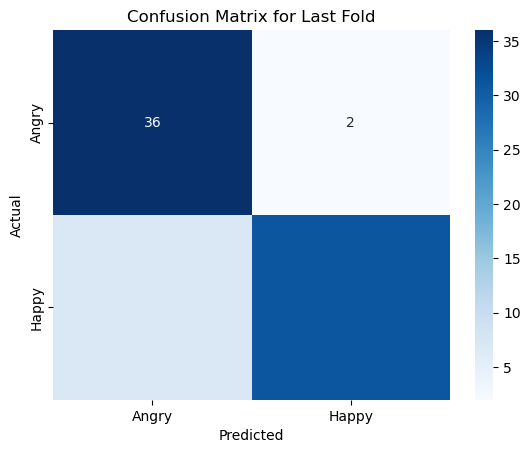

Classification Report for the last fold:
              precision    recall  f1-score   support

       Angry       0.84      0.95      0.89        38
       Happy       0.94      0.82      0.87        38

    accuracy                           0.88        76
   macro avg       0.89      0.88      0.88        76
weighted avg       0.89      0.88      0.88        76

Average Cross-Validation Accuracy: 86.98%
Average Precision: 0.89
Average Recall: 0.84
Average F1-Score: 0.87


In [28]:
# Initialize your model
model = EmotionModel()

# Run cross-validation
average_accuracy, avg_precision, avg_recall, avg_f1 = run_cross_validation(model, X_scaled, y)

# Print overall average results
print(f"Average Cross-Validation Accuracy: {average_accuracy:.2f}%")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1-Score: {avg_f1:.2f}")
